In [84]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

# Estudio de consumo de frutas y vegetales por paises de la Unión Europea

## Paso 1: importado de datos CSV

In [85]:
#IMPORTAR CSV
df=pd.read_csv("Data/daily_consumption_fruit_vegetables_eu.csv")
print('Forma del Dataframe: ',df.shape)
print('Tamaño del Dataframe: ',df.size)

Forma del Dataframe:  (43488, 7)
Tamaño del Dataframe:  304416


In [86]:
#ESCRIBIR CABECERA (5 ROWS)
df.head()

,unit,n_portion,sex,age,country,time,value
0,PC,0,F,TOTAL,AT,2019,29.1
1,PC,0,F,TOTAL,BE,2019,17.1
2,PC,0,F,TOTAL,BG,2019,54.2
3,PC,0,F,TOTAL,CY,2019,32.7
4,PC,0,F,TOTAL,CZ,2019,49.6


### Extraemos solo los datos necesarios para nuestro estudio. En este caso, los datos del año 2019(el último)

In [87]:
#EXTRAER EL ÚLTIMO AÑO
ultimoAnio=df["time"].max()
print("año:",ultimoAnio)
df_LastYear=df[(df["time"] >= 2014) & (df["time"] <= 2019)]
print('Forma del Dataframe: ',df_LastYear.shape)
print('Tamaño del Dataframe: ',df_LastYear.size)


año: 2019
Forma del Dataframe:  (43488, 7)
Tamaño del Dataframe:  304416


In [88]:
df_LastYear.head()
df_LastYear.tail()

,unit,n_portion,sex,age,country,time,value
43483,PC,GE5,T,Y_GE75,SE,2014,6.8
43484,PC,GE5,T,Y_GE75,SI,2014,6.6
43485,PC,GE5,T,Y_GE75,SK,2014,10.1
43486,PC,GE5,T,Y_GE75,TR,2014,2.7
43487,PC,GE5,T,Y_GE75,UK,2014,34.3


## Paso 2: Limpieza de datos

### Limpieza previa de tipos

In [89]:
#DESCRIBO EL DATAFRAME PARA LIMPIAR CORRECTAMENTE POR COLUMNAS
df_LastYear.info()
print('columnas del DataFrame:',df_LastYear.columns)

#LIMPIEZA PREVIA DE TIPOS
df["country"] = df["country"].astype(str).str.strip()
df["sex"] = df["sex"].astype(str).str.strip()
df["time"] = df["time"].astype(str).str.strip()
df["value"] = pd.to_numeric(df["value"], errors="coerce")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43488 entries, 0 to 43487
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   unit       43488 non-null  object 
 1   n_portion  43488 non-null  object 
 2   sex        43488 non-null  object 
 3   age        43488 non-null  object 
 4   country    43488 non-null  object 
 5   time       43488 non-null  int64  
 6   value      35610 non-null  float64
dtypes: float64(1), int64(1), object(5)
memory usage: 2.3+ MB
columnas del DataFrame: Index(['unit', 'n_portion', 'sex', 'age', 'country', 'time', 'value'], dtype='object')


### Limpieza profunda de datos: rellenar nulos, eliminar datos innecesarios o que distorsionen...etc

In [90]:
#VERIFICO QUE NO HAY PAISES EXTRAÑOS O GRUPOS DE PAISES
print('Valores de country en DataFrame original:',df["country"].unique())

# Eliminar agregaciones de la UE
paises_a_eliminar = ["EU28", "EU27_2020"]
df_limpio = df_LastYear[~df_LastYear["country"].isin(paises_a_eliminar)]

print('Países en DataFrame limpio:',df_limpio["country"].unique())
print("_"*50)

#VERIFICO LOS VALORES DE SEXO
print('Valores de sexo en DataFrame original:',df["sex"].unique())
df_limpio = df_limpio[df_limpio["sex"].isin(["F", "M"])]
print('Valores de sexo en DataFrame limpio:',df_limpio["sex"].unique())
print("_"*50)

#COMPROBAMOS QUE LOS RANGOS DE EDAD SON CORRECTOS
print('Valores de age en DataFrame original:',df["age"].unique())

import re
pattern = r"^Y\d{1,3}-\d{1,3}$"   
mask_edades = df_limpio["age"].str.match(pattern, na=False)

#FILTRAR Y VER
df_limpio = df_limpio[mask_edades].copy()
print("Edades únicas después:",(df_limpio["age"].unique()))

elegidos = ["Y15-24","Y25-34","Y35-44","Y45-64","Y65-74"]
df_limpio = df_limpio[df_limpio["age"].isin(elegidos)].copy()
print('Rangos elegidos de edad:',df_limpio["age"].unique())


print("_"*50)

#EL PRIMER PROBLEMA QUE OBSERVO, ES QUE HAY "value" VACIOS, relleno con la media.
#luego veo que hay ceros, que también los voy a reemplazar por la media.
#Para mayor precisión, lo hago con la media global, no con la de año.

#ANALIZO VALORES NULOS Y CEROS Y REEMPLAZO LOS ZEROS POR NAN PARA NO INFLUIR EN LA MEDIA
print('Cantidad de valores nulos en el dataframe original:',df_LastYear["value"].isna().replace(0,np.nan).sum())
print('Cantidad de ceros en el dataframe original:',(df_LastYear["value"]==0).sum())
print("_"*50)

#CALCULO LA MEDIA GLOBAL
media_valor=df_limpio["value"].mean().round(1)
print('La media global de valor de consumo es:',media_valor)
print("_"*50)

#REEMPLAZO VALORES NULOS Y CEROS POR LA MEDIA GLOBAL
#df_limpio = df_LastYear.copy()
df_limpio["value"] = df_limpio["value"].fillna(media_valor)
# Reemplazar ceros por la media por país

def calcular_media_sin_ceros(grupo):
    """Calcula la media excluyendo los ceros"""
    return grupo[grupo != 0].mean()

media_por_pais = df_limpio.groupby("country")["value"].transform(calcular_media_sin_ceros)
df_limpio.loc[df_limpio["value"]==0, "value"] = media_por_pais

print('Cantidad de valores nulos actualizada:',df_limpio["value"].isna().sum())
print('Cantidad de ceros actualizada:',(df_limpio["value"]==0).sum())
print("_"*50)





Valores de country en DataFrame original: ['AT' 'BE' 'BG' 'CY' 'CZ' 'DE' 'DK' 'EE' 'EL' 'ES' 'EU27_2020' 'EU28' 'FI'
 'FR' 'HR' 'HU' 'IE' 'IS' 'IT' 'LT' 'LU' 'LV' 'MT' 'NL' 'NO' 'PL' 'PT'
 'RO' 'RS' 'SE' 'SI' 'SK' 'TR' 'UK']
Países en DataFrame limpio: ['AT' 'BE' 'BG' 'CY' 'CZ' 'DE' 'DK' 'EE' 'EL' 'ES' 'FI' 'FR' 'HR' 'HU'
 'IE' 'IS' 'IT' 'LT' 'LU' 'LV' 'MT' 'NL' 'NO' 'PL' 'PT' 'RO' 'RS' 'SE'
 'SI' 'SK' 'TR' 'UK']
__________________________________________________
Valores de sexo en DataFrame original: ['F' 'M' 'T']
Valores de sexo en DataFrame limpio: ['F' 'M']
__________________________________________________
Valores de age en DataFrame original: ['TOTAL' 'Y15-19' 'Y15-24' 'Y15-29' 'Y15-44' 'Y15-64' 'Y20-24' 'Y25-29'
 'Y25-34' 'Y25-64' 'Y35-44' 'Y45-54' 'Y45-64' 'Y55-64' 'Y65-74' 'Y_GE18'
 'Y_GE65' 'Y_GE75']
Edades únicas después: ['Y15-19' 'Y15-24' 'Y15-29' 'Y15-44' 'Y15-64' 'Y20-24' 'Y25-29' 'Y25-34'
 'Y25-64' 'Y35-44' 'Y45-54' 'Y45-64' 'Y55-64' 'Y65-74']
Rangos elegidos de edad: [

## Paso 3: análisis

### Muestra de promedio de consumo en gramos por país

In [91]:
#UNA VEZ LIMPIO, PRETENDO MOSTRAR UN RESUMEN DE MEDIA POR PAIS

df_resumen=df_limpio.groupby("country")["value"].mean().reset_index()
df_resumen.set_index("country", inplace=True)
df_resumen.sort_values(by="value", ascending=False, inplace=True)   
print('Resumen de los primeros cinco paises con mayor consumo diario de frutas y verduras:')
print(df_resumen.head())
print("_"*50)
print('Resumen de los últimos cinco paises con menor consumo diario de frutas y verduras:')
print(df_resumen.tail())

Resumen de los primeros cinco paises con mayor consumo diario de frutas y verduras:
             value
country           
CZ       33.895763
SK       33.894915
SI       33.612185
IS       33.612185
PL       33.611765
__________________________________________________
Resumen de los últimos cinco paises con menor consumo diario de frutas y verduras:
             value
country           
LU       33.330000
BG       33.329583
HR       33.327917
RS       33.317500
UK       33.317083


## Paso 4: comunicación de datos y visualización

### Mostramos gráficos de consumo por país

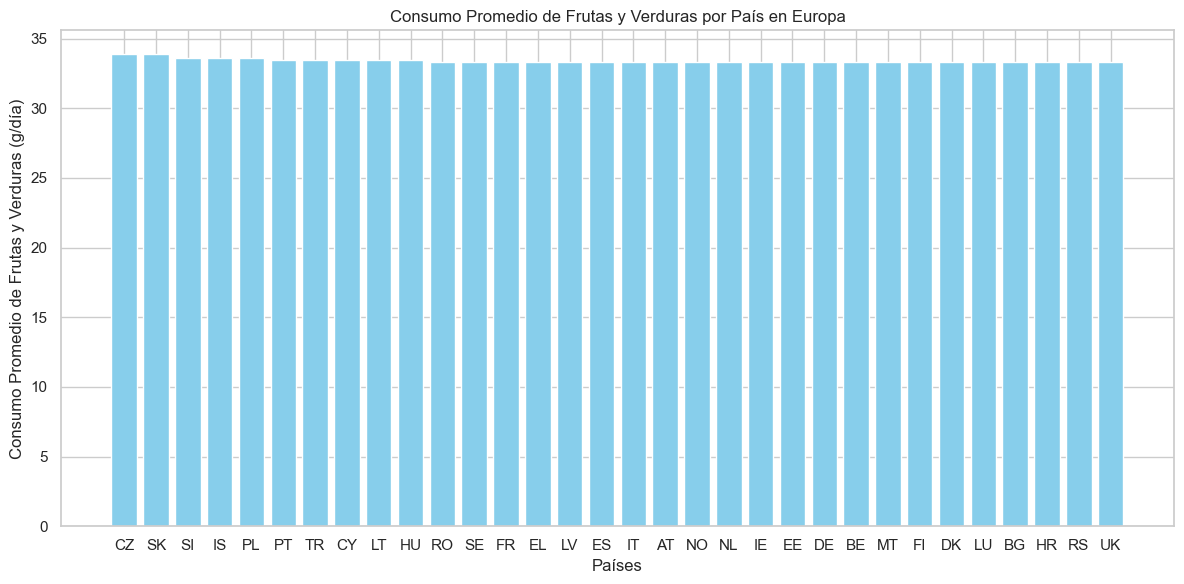

In [92]:
#MUESTRO UN GRÁFICO PARA VER MEJOR LA DIFERENCIA ENTRE PAÍSES

paises = df_resumen.index
consumo = df_resumen["value"]

plt.figure(figsize=(12, 6))
plt.bar(paises, consumo, color='skyblue')
plt.xlabel('Países')
plt.ylabel('Consumo Promedio de Frutas y Verduras (g/día)')
plt.title('Consumo Promedio de Frutas y Verduras por País en Europa')
plt.tight_layout()
plt.show()


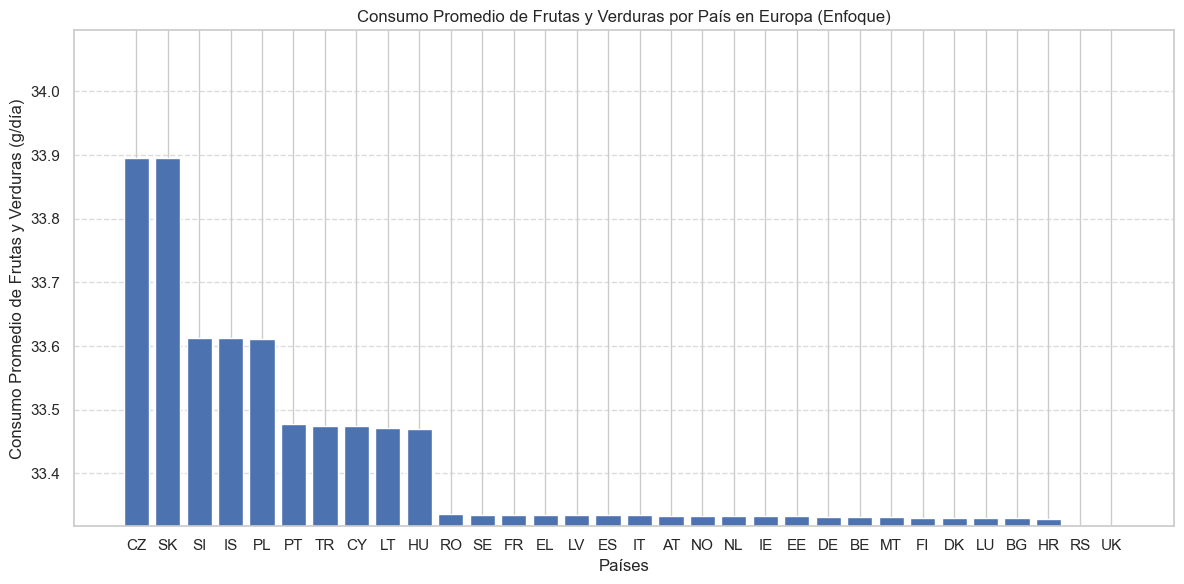

In [93]:
#OTRO GRÁFICO DE BARRAS CON LÍMITES MÁS JUSTOS
plt.figure(figsize=(12, 6))
plt.bar(paises, consumo)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(np.min(consumo), np.max(consumo)+0.2)  # Ajusta los límites del eje y para enfocarte en el rango relevante
plt.xlabel('Países')    
plt.ylabel('Consumo Promedio de Frutas y Verduras (g/día)')
plt.title('Consumo Promedio de Frutas y Verduras por País en Europa (Enfoque)')
plt.tight_layout()      
plt.show()

### Analizamos el sexo en relación al consumo y mostramos gráfico

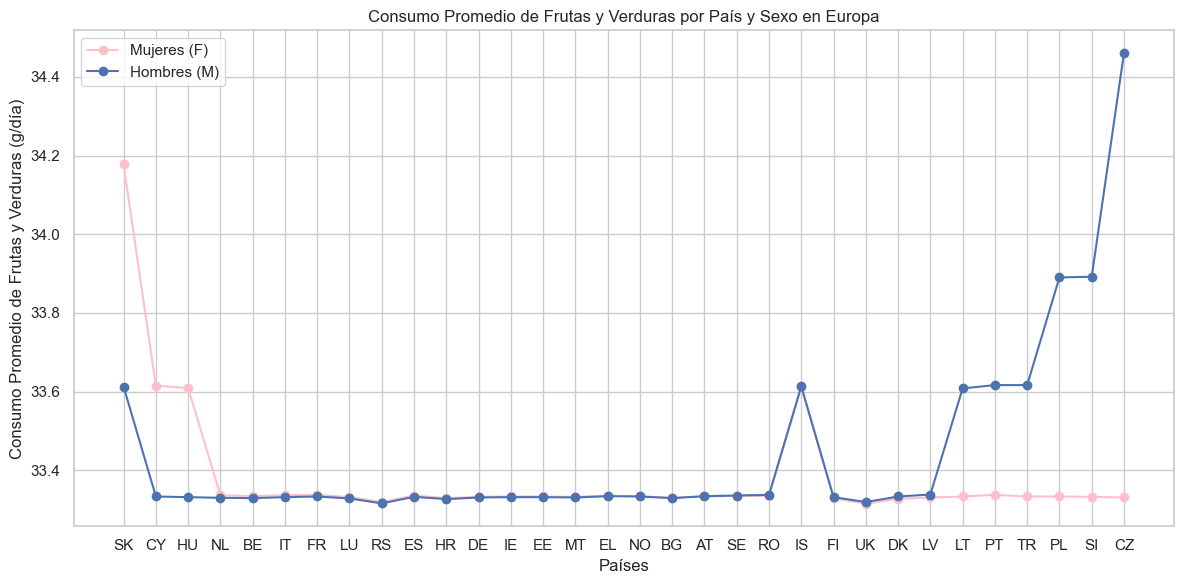

In [94]:
#AHORA QUIERO VER LA DIFERENCIA ENTRE SEXOS EN CADA PAÍS
#AGRUPO POR SEXOS Y DESPUÉS HAGO UN PIVOT PARA TENERLOS EN COLUMNAS
df_sexo = df_limpio.groupby(["country","sex"])["value"].mean().reset_index()
df_sexo_pivot = df_sexo.pivot(index="country", columns="sex", values="value")
df_sexo_pivot["diferencia"] = df_sexo_pivot.get("F", pd.Series(dtype=float)) - df_sexo_pivot.get("M", pd.Series(dtype=float))
df_sexo_pivot.sort_values(by="diferencia", ascending=False, inplace=True)

#EXTRAIGO ARRAYS PARA EL GRÁFICO
f = df_sexo_pivot["F"]
m = df_sexo_pivot["M"]

paises = df_sexo_pivot.index
x = np.arange(len(paises))

plt.figure(figsize=(12, 6))
plt.plot(x, f, label='Mujeres (F)', marker='o', color='pink')
plt.plot(x, m, label='Hombres (M)', marker='o')
plt.xticks(x, paises)
plt.title('Consumo Promedio de Frutas y Verduras por País y Sexo en Europa')
plt.xlabel('Países')
plt.ylabel('Consumo Promedio de Frutas y Verduras (g/día)')
plt.legend()

plt.tight_layout()
plt.show()


### Análisis de consumo por rangos de edades

In [95]:
#VAMOS A HACER UN ANÁLISIS POR EDADES TAMBIÉN
df_edad = df_limpio.groupby(["age"])["value"].mean()
print(df_edad.head())


age
Y15-24    33.438691
Y25-34    33.397774
Y35-44    33.507739
Y45-64    33.332617
Y65-74    33.398505
Name: value, dtype: float64


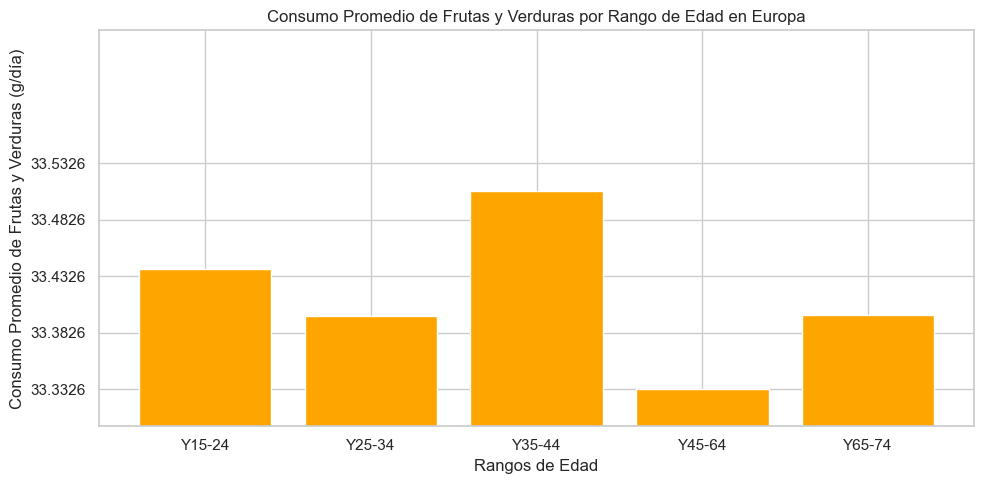

In [96]:
#GRAFICO DE BARRAS PARA ANALIZAR POR RANGOS DE EDADES
rangos_edad=df_edad.index
consumo_edad=df_edad.values

# Incrementos de 0.05 para máxima granularidad
yticks = np.arange(min(consumo_edad),max(consumo_edad) + 0.05, 0.05)

plt.figure(figsize=(10, 5))
#limites más justos para ver mejor la diferencia
plt.ylim(33.3, 33.65)
plt.bar(rangos_edad, consumo_edad, color='orange')
plt.xlabel('Rangos de Edad')
plt.ylabel('Consumo Promedio de Frutas y Verduras (g/día)') 
plt.title('Consumo Promedio de Frutas y Verduras por Rango de Edad en Europa')
plt.yticks(yticks)
plt.tight_layout()
plt.show()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_19976\3075240822.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='age', y='value', data=df_edad, palette='viridis')


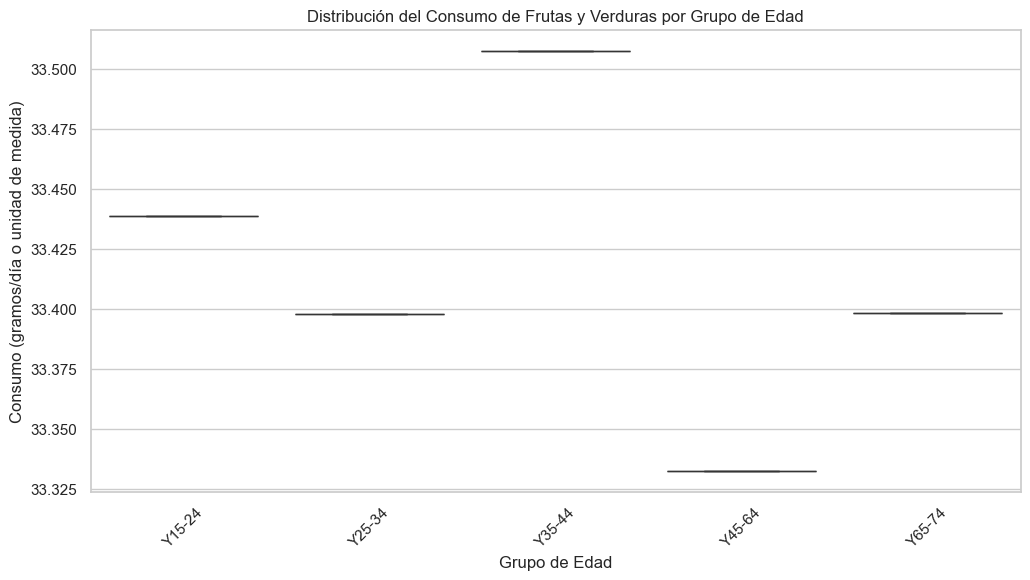

In [97]:
# Asegúrate de que los nombres de las columnas coincidan con tu DataFrame
df_edad=df_edad.reset_index()
plt.figure(figsize=(12, 6))
sns.boxplot(x='age', y='value', data=df_edad, palette='viridis')
plt.title('Distribución del Consumo de Frutas y Verduras por Grupo de Edad')
plt.xlabel('Grupo de Edad')
plt.ylabel('Consumo (gramos/día o unidad de medida)')
plt.xticks(rotation=45)
plt.show()

## Paso extra: preparación de datos para uso de compañeros

### Aquí escribo un resumen de los dataframes y series utilizados en limpio para facilitar la extracción de los mismos por parte de mis compañeros

In [98]:
#DATAFRAMES EXTRAIDOS
df_final=df_limpio.copy()
df_paises = df_resumen.copy()
df_sexos = df_sexo_pivot.copy()
df_edades = df_edad.copy()
#_______________________________________________________________________________________
print('RESUMEN DE DATAFRAMES EXTRAIDOS:')
print("-"*50)

print("DATAFRAME LIMPIO:")
print(df_final.head())
print("_"*50)

print("VALORES EN GRAMOS DE CONSUMO PROMEDIO POR PAÍS:")
print(df_paises.head())
print("_"*50)

print("VALORES EN GRAMOS DE CONSUMO PROMEDIO POR SEXO Y PAÍS:")
print(df_sexos.head())
print("_"*50)

print("VALORES EN GRAMOS DE CONSUMO PROMEDIO POR RANGO DE EDAD:")
print(df_edades.head())
print("_"*50)

RESUMEN DE DATAFRAMES EXTRAIDOS:
--------------------------------------------------
DATAFRAME LIMPIO:
   unit n_portion sex     age country  time  value
66   PC         0   F  Y15-24      AT  2019   37.6
67   PC         0   F  Y15-24      BE  2019   23.5
68   PC         0   F  Y15-24      BG  2019   43.9
69   PC         0   F  Y15-24      CY  2019   39.3
70   PC         0   F  Y15-24      CZ  2019   42.2
__________________________________________________
VALORES EN GRAMOS DE CONSUMO PROMEDIO POR PAÍS:
             value
country           
CZ       33.895763
SK       33.894915
SI       33.612185
IS       33.612185
PL       33.611765
__________________________________________________
VALORES EN GRAMOS DE CONSUMO PROMEDIO POR SEXO Y PAÍS:
sex              F          M  diferencia
country                                  
SK       34.177373  33.612458    0.564915
CY       33.614784  33.333333    0.281450
HU       33.608919  33.331667    0.277252
NL       33.336667  33.330000    0.006667
BE

In [99]:
#SERIES EXTRAIDAS
serie_paises = df_resumen["value"].copy() 
serie_hombres = df_sexo_pivot["M"].copy()
serie_mujeres = df_sexo_pivot["F"].copy() 
serie_consumo_edad = df_edad.values.copy()

In [100]:
# Mapeo completo de códigos ISO 2 a nombres de países (principalmente UE y candidatos/afiliados)
mapa_paises = {
    'AT': 'Austria',
    'BE': 'Bélgica',
    'BG': 'Bulgaria',
    'CY': 'Chipre',
    'CZ': 'República Checa',
    'DE': 'Alemania',
    'DK': 'Dinamarca',
    'EE': 'Estonia',
    'EL': 'Grecia',
    'ES': 'España',
    'FI': 'Finlandia',
    'FR': 'Francia',
    'HR': 'Croacia',
    'HU': 'Hungría',
    'IE': 'Irlanda',
    'IT': 'Italia',
    'LT': 'Lituania',
    'LU': 'Luxemburgo',
    'LV': 'Letonia',
    'MT': 'Malta',
    'NL': 'Países Bajos',
    'PL': 'Polonia',
    'PT': 'Portugal',
    'RO': 'Rumanía',
    'SE': 'Suecia',
    'SI': 'Eslovenia',
    'SK': 'Eslovaquia',
    'IS': 'Islandia',
    
    # Países no UE o totales de grupos
    'GB': 'Reino Unido',
    'CH': 'Suiza',
    'NO': 'Noruega',  
    'RS': 'Serbia',  
    'TR': 'Turquía', 
    'UK': 'Reino Unido', 
    'EU27_2020': 'UE (27 países - 2020)',
    'EU28': 'UE (28 países - pre-Brexit)',
    'EA19': 'Eurozona (19 países)' # Posiblemente presente en tu dataset
}
%store mapa_paises



df_edadPais=df_limpio.groupby(["country","time","age"])["value"].mean().reset_index()
df_limpio["country"]=df_limpio["country"].replace(mapa_paises)

# 1. Aplicar el reemplazo a la columna 'country' usando el diccionario de mapeo
# El método .replace() es seguro y reemplazará solo las claves que encuentre.
df_edadPais['country'] = df_edadPais['country'].replace(mapa_paises)

# 2. Verificación de éxito
print("✅ ¡Mapeo completado! Nuevos nombres de países:")
print(df_edadPais['country'].unique())

# 3. Mostrar las primeras filas del DataFrame actualizado
print("\nPrimeras filas de df_edadPais con nombres de país completos:")
print(df_edadPais.head())

df_frutas=df_edadPais.loc[df_edadPais["age"]=="Y15-24"]
%store df_frutas

df_frutas.to_csv("dataframes_limpios/df_frutas.csv", index=False)
df_frutas.head(32)

Stored 'mapa_paises' (dict)
✅ ¡Mapeo completado! Nuevos nombres de países:
['Austria' 'Bélgica' 'Bulgaria' 'Chipre' 'República Checa' 'Alemania'
 'Dinamarca' 'Estonia' 'Grecia' 'España' 'Finlandia' 'Francia' 'Croacia'
 'Hungría' 'Irlanda' 'Islandia' 'Italia' 'Lituania' 'Luxemburgo' 'Letonia'
 'Malta' 'Países Bajos' 'Noruega' 'Polonia' 'Portugal' 'Rumanía' 'Serbia'
 'Suecia' 'Eslovenia' 'Eslovaquia' 'Turquía' 'Reino Unido']

Primeras filas de df_edadPais con nombres de país completos:
   country  time     age      value
0  Austria  2014  Y15-24  33.325000
1  Austria  2014  Y25-34  33.341667
2  Austria  2014  Y35-44  33.337500
3  Austria  2014  Y45-64  33.329167
4  Austria  2014  Y65-74  33.333333
Stored 'df_frutas' (DataFrame)


,country,time,age,value
0,Austria,2014,Y15-24,33.325000
5,Austria,2019,Y15-24,33.337500
10,Bélgica,2014,Y15-24,33.333333
15,Bélgica,2019,Y15-24,33.333333
20,Bulgaria,2014,Y15-24,33.316667
25,Bulgaria,2019,Y15-24,33.316667
30,Chipre,2014,Y15-24,33.329167
35,Chipre,2019,Y15-24,33.333333
40,República Checa,2014,Y15-24,33.333333
45,República Checa,2019,Y15-24,33.325000


In [101]:
print(df_edad.columns)

Index(['age', 'value'], dtype='object')


## SEABORN

C:\Users\Usuario\AppData\Local\Temp\ipykernel_19976\3094504626.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


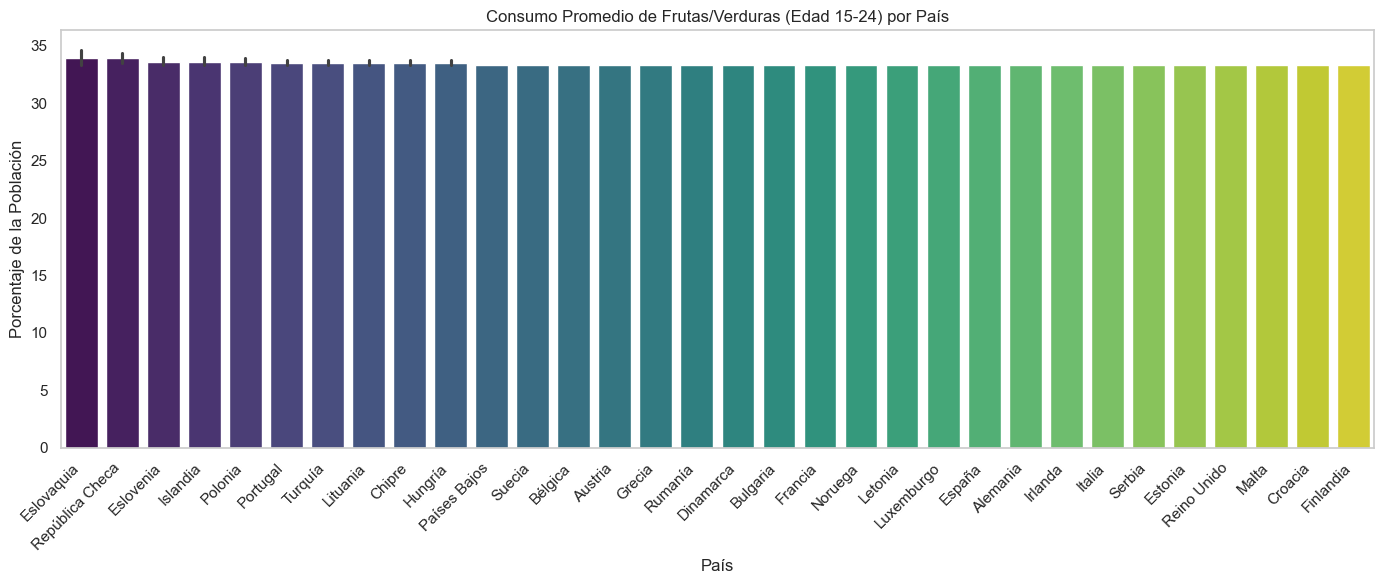

In [102]:

plt.figure(figsize=(14, 6))
# Usamos 'country' en el eje x y 'value' (consumo promedio) en el eje y
sns.barplot(
    data=df_edadPais.sort_values(by='value', ascending=False),
    x='country',
    y='value',
    palette='viridis'
)
plt.title('Consumo Promedio de Frutas/Verduras (Edad 15-24) por País')
plt.xlabel('País')
plt.ylabel('Porcentaje de la Población')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_19976\3285700619.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


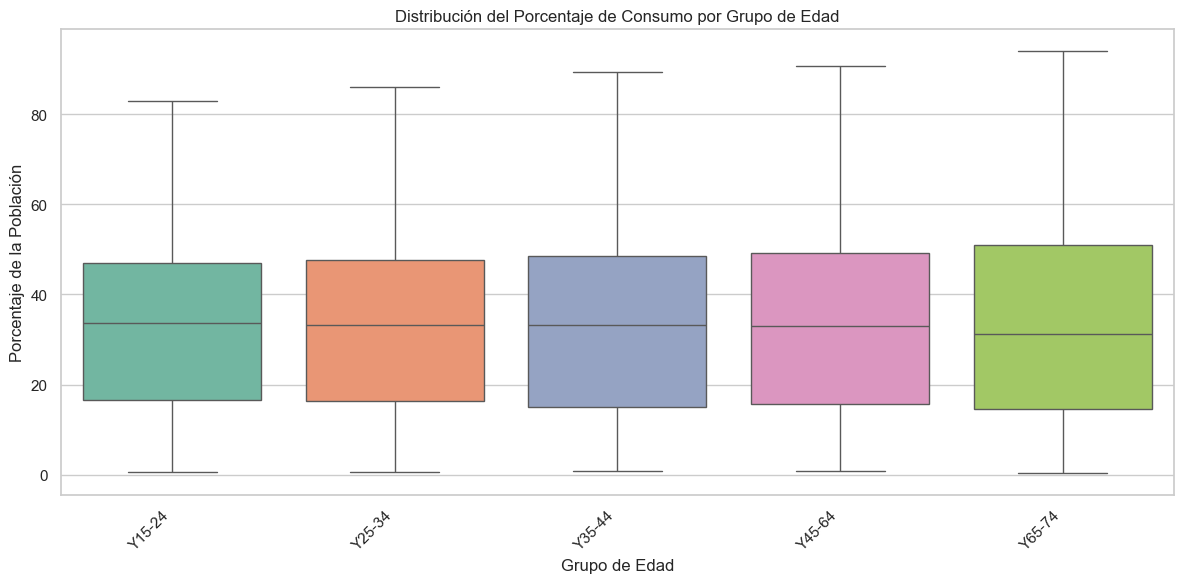

In [103]:
plt.figure(figsize=(12, 6))
# Box plot para ver la distribución del consumo por cada grupo de edad
sns.boxplot(
    data=df_limpio,
    x='age',
    y='value',
    palette='Set2')
    #order=sorted(df_limpio['age'].unique()) # Opcional: para ordenar los grupos de edad si son categóricos
#)
plt.title('Distribución del Porcentaje de Consumo por Grupo de Edad')
plt.xlabel('Grupo de Edad')
plt.ylabel('Porcentaje de la Población')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

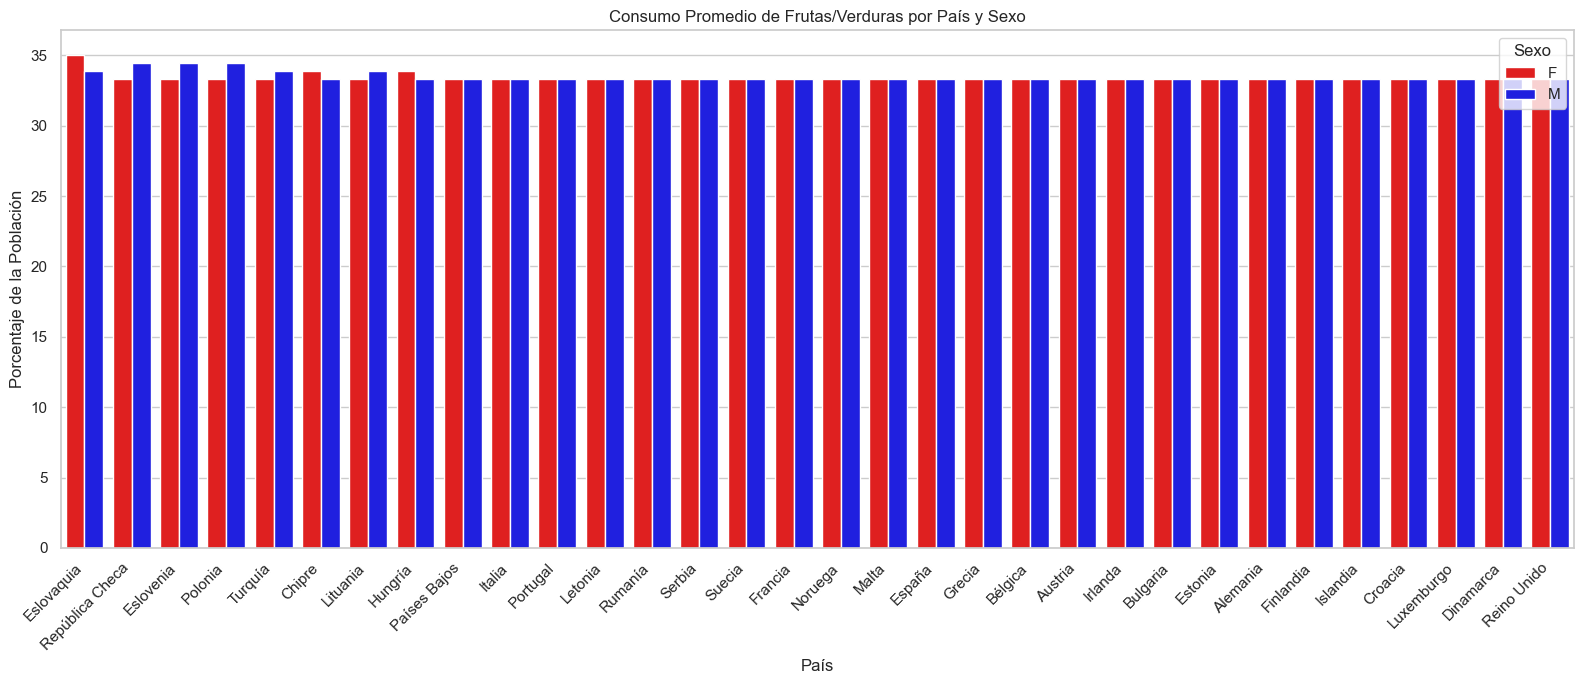

In [107]:
#Preprocesamiento: Agrupar por país y sexo para el consumo promedio
df_2019 = df_limpio[df_limpio["time"] == 2019]
df_sex_pais = df_2019.groupby(['country', 'sex'])['value'].mean().reset_index()


plt.figure(figsize=(16, 7))
sns.barplot(
    data=df_sex_pais.loc[df_sex_pais['sex'].isin(['F', 'M'])].sort_values(by='value', ascending=False), # Filtrar por F, M y TOTAL
    x='country',
    y='value',
    hue='sex',#'sex' para separar las barras
    palette={'F': 'red', 'M': 'blue'}
)
plt.title('Consumo Promedio de Frutas/Verduras por País y Sexo')
plt.xlabel('País')
plt.ylabel('Porcentaje de la Población')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sexo')
plt.tight_layout()
plt.show()

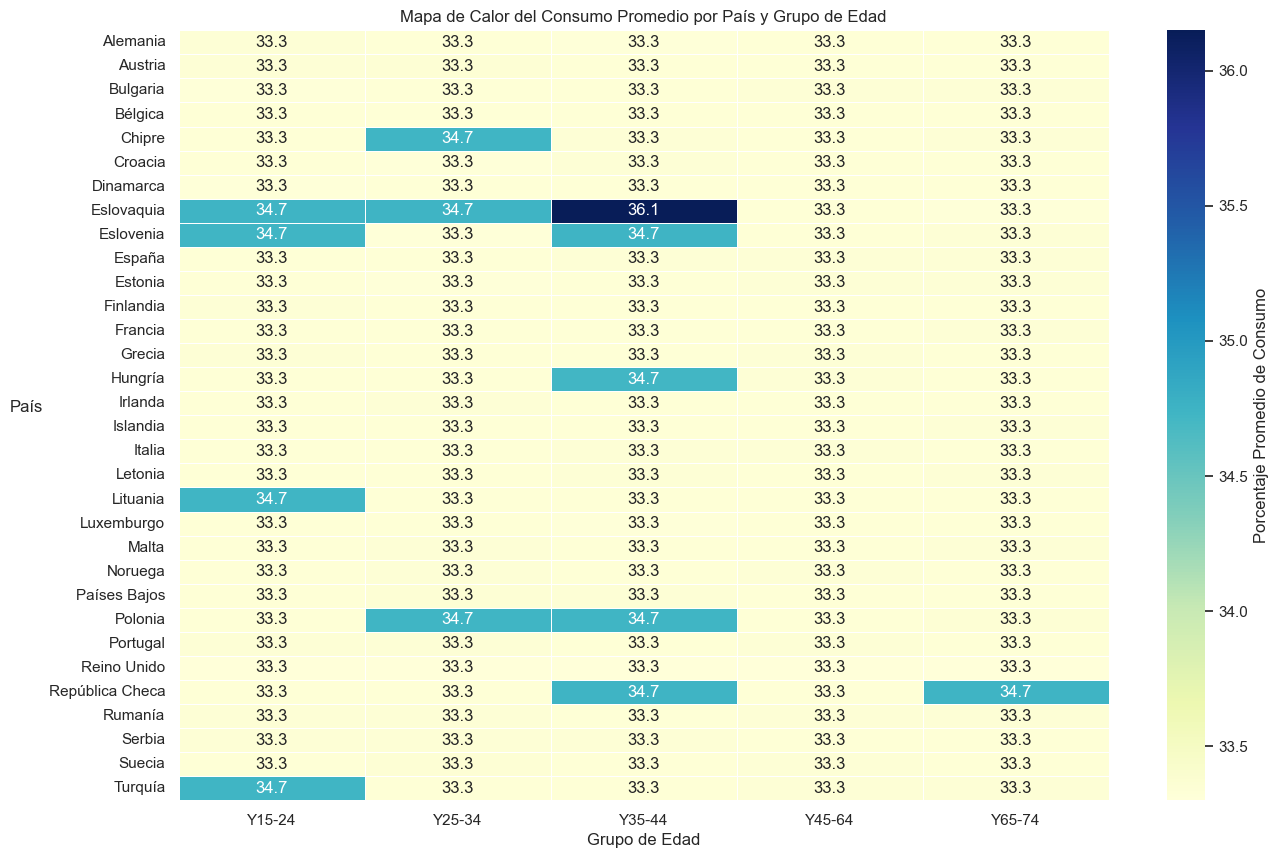

In [111]:

df_heatmap = df_2019.groupby(['country', 'age'])['value'].mean().unstack()

plt.figure(figsize=(15, 10))
sns.heatmap(
    df_heatmap,
    annot=True,       #MOSTRAR VALOR
    fmt=".1f",       
    cmap="YlGnBu",    #Escala de color (Yellow-Green-Blue, ideal para datos de intensidad)
    linewidths=.5,    # Líneas para separar las celdas
    cbar_kws={'label': 'Porcentaje Promedio de Consumo'}
)
plt.title('Mapa de Calor del Consumo Promedio por País y Grupo de Edad')
plt.xlabel('Grupo de Edad')
plt.ylabel('País',rotation=0, ha="right")
plt.yticks(rotation=0, ha="right")
plt.show()

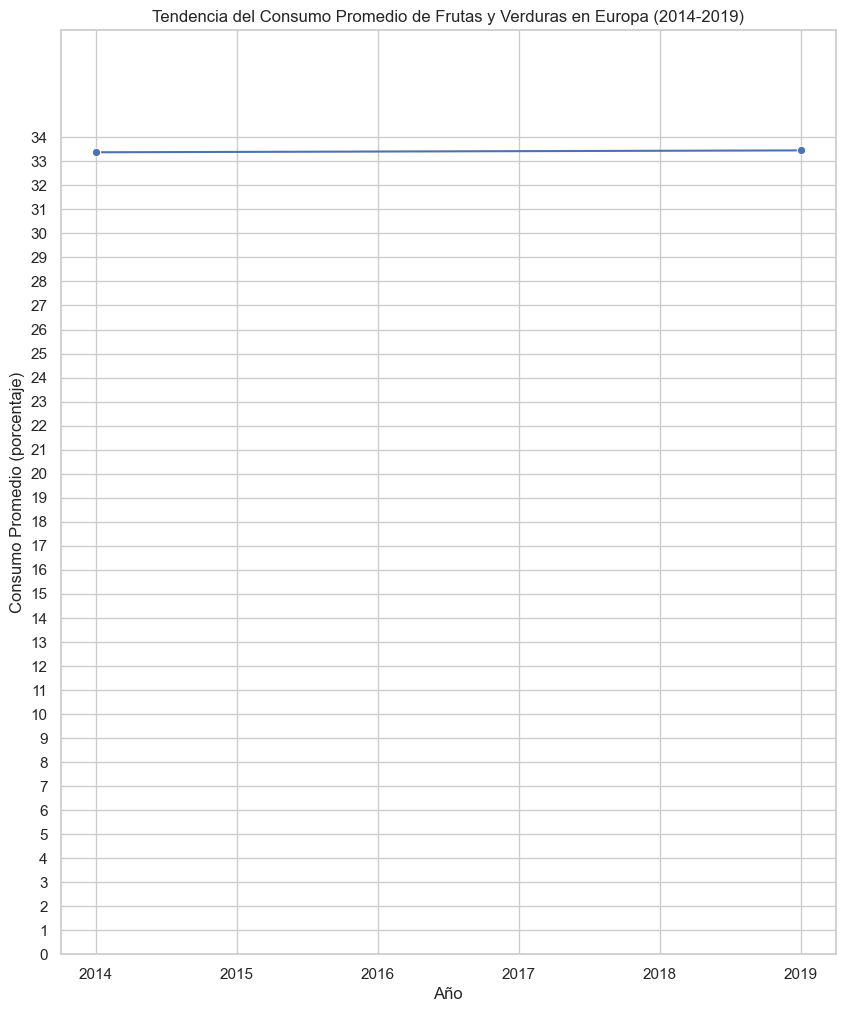

In [106]:
df_mediaAnio=df_limpio.groupby("time")["value"].mean().reset_index()
df_mediaAnio.head()

plt.figure(figsize=(10, 12)) 

sns.lineplot(data=df_mediaAnio, x="time", y="value", marker="o")
plt.title("Tendencia del Consumo Promedio de Frutas y Verduras en Europa (2014-2019)")
plt.xlabel("Año")   
plt.ylabel("Consumo Promedio (porcentaje)")

plt.yticks(np.arange(0, df_mediaAnio["value"].max() + 1, 1))
plt.ylim(0, df_mediaAnio["value"].max() + 5)

plt.show()

